In [1]:
import os
import cv2
import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tifffile import imread

np.set_printoptions(precision = 2)
np.set_printoptions(suppress  = True)

In [2]:
def normalize(img):
    img_cop  = img.copy()
    img_cop  = img_cop.astype('float64') 
    img_min  = np.min(img_cop)
    img_max  = np.max(img_cop)
    img_cop  = (img_cop - img_min)/(img_max - img_min)
    return img_cop

In [3]:
model = tf.keras.models.load_model('model_segmentation.h5')
img   = imread('labelme/multi_recorte_2.tif')

In [4]:
img_height    = 256
img_width     = 256
img_channels  = 3

# Parameters
Nx, Ny, Nz = img.shape
Nw   = 256
step = round(Nw/5)

# Index images
indx_x = np.unique(np.concatenate(([np.arange(0, Nx-Nw, step)], [np.array([Nx-Nw])]), axis = 1))
indx_y = np.unique(np.concatenate(([np.arange(0, Ny-Nw, step)], [np.array([Ny-Nw])]), axis = 1))

N      = indx_x.size*indx_y.size

# Cut images
cntr   = 0
X_test = np.zeros((N, Nw, Nw, Nz))
for i in indx_x:
    for j in indx_y:
        i_idx = np.arange(i, i+Nw)
        j_idx = np.arange(j, j+Nw)
        block = img[i_idx[:, None], j_idx[None, :], :]
        block = np.around(255*normalize(block)).astype('uint8')
        X_test[cntr] = block
        cntr  += 1

# Predict images
Y_test_pred = model.predict(X_test, verbose=0)

In [5]:
cntr = 0
bufr_1 = np.zeros((Nx, Ny, Nz))
bufr_2 = np.zeros((Nx, Ny, Nz))
for i in indx_x:
    for j in indx_y:
        i_idx = np.arange(i, i+Nw)
        j_idx = np.arange(j, j+Nw)
        predi  = Y_test_pred[cntr]
        bufr_1[i_idx[:, None], j_idx[None, :], :] = bufr_1[i_idx[:, None], j_idx[None, :], :] + predi;
        bufr_2[i_idx[:, None], j_idx[None, :], :] = bufr_2[i_idx[:, None], j_idx[None, :], :] + 1;
        cntr  += 1

all_preditions = np.around(255*normalize(bufr_1/bufr_2)).astype('uint8')

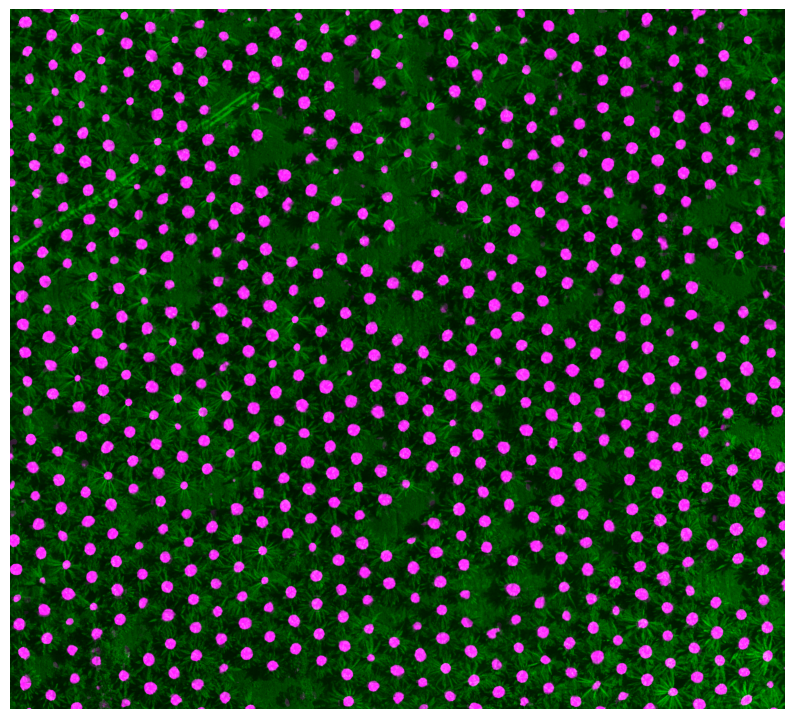

In [6]:
img1     = all_preditions[:,:,0]
img2     = img[:,:,0]
img_all  = np.dstack((img1,img2,img1))

fig, axs = plt.subplots(figsize = (10,10))
axs.imshow(img_all)
axs.axis('off')
plt.show()

In [7]:
img_pred  = all_preditions[:,:,0].copy()
# Convert the image to grayscale
img_pred_gauss = gray_blurred = cv2.GaussianBlur(img_pred, (15, 15), 0)

# Use the HoughCircles method to detect circles
circles = cv2.HoughCircles(
    img_pred_gauss,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=20,
    param1=50,
    param2=30,
    minRadius=5,
    maxRadius=100
)

output = np.zeros(img_pred.shape, dtype = 'float32')

# Ensure at least some circles were found
if circles is not None:
    # Convert the circle parameters (x, y, radius) to integers
    circles = np.round(circles[0, :]).astype("int")

    # Loop over the detected circles
    for (x, y, r) in circles:
        # Draw the circle in the output image
        cv2.circle(output, (x, y), r, (255, 255, 255), 2)


    # Print the number of circles detected
    print(f"Number of circles detected: {len(circles)}")

Number of circles detected: 639


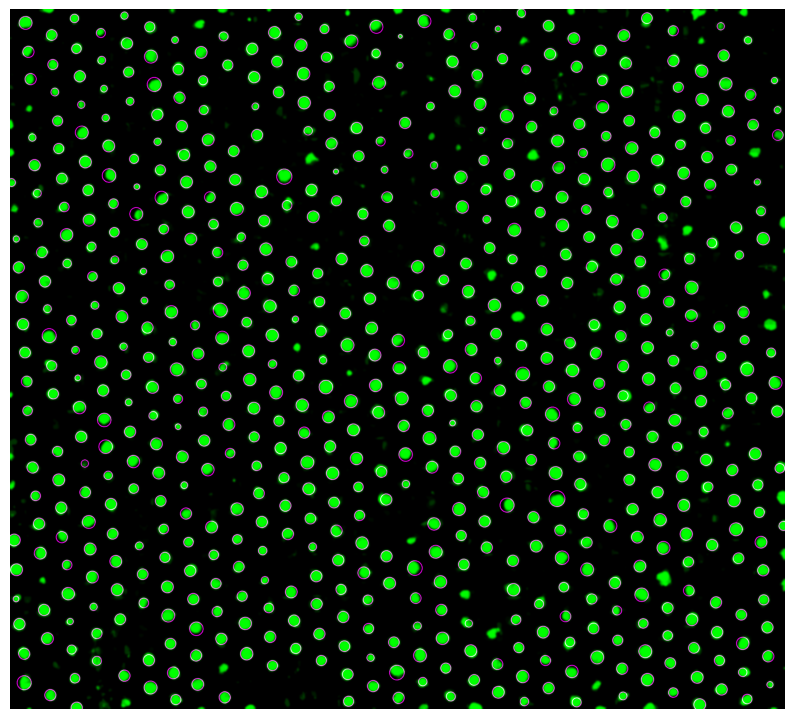

In [8]:
img3     = output
img4     = img_pred_gauss
img_all  = np.dstack((img3,img4,img3))

fig, axs = plt.subplots(figsize = (10,10))
axs.imshow(img_all/np.max(img_all))
axs.axis('off')
plt.show()